running for TSS spin N= 10 nprocs= 12  !


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 22107.61it/s]


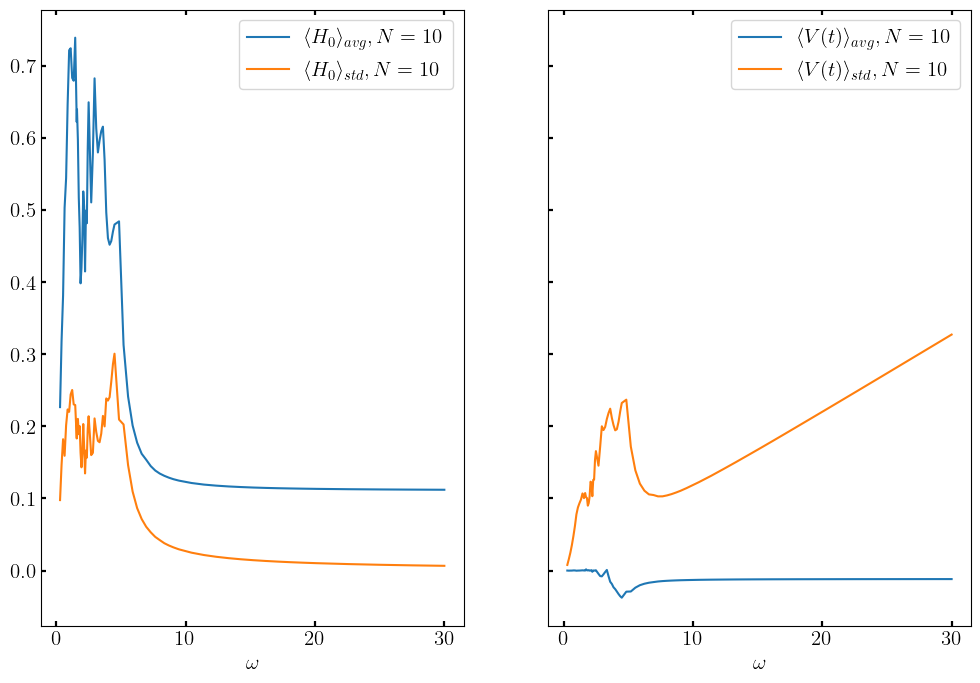

CPU times: user 2.19 s, sys: 1.69 s, total: 3.87 s
Wall time: 1min 21s


In [2]:

%%time
import h5py
from qutip import mesolve, basis, jmat, Options, expect, Qobj
from multiprocessing import Pool
from tqdm import tqdm
from scipy.special import jn_zeros
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({"figure.figsize": (12,8),"text.usetex": True,
    "font.family": "sans-serif","font.size": 15,"font.sans-serif": ["Computer Modern"]})

def drive(t, args):
    w = args['omega']
    h = args['h']
    h0 = args['h0']
    return h * np.sin(w*t) + h0

def get_hamiltonians(N):
    sx,sy,sz = jmat(N,"x"),jmat(N,"y"),jmat(N,"z")
    kn =  2.0/(N-1)                                     
    H0 = kn * sz **2 
    H1 = 2 * sx
    return H0,H1

def sys_evolve_stat(w,N,opts):
    sx,sy,sz = jmat(N,"x"),jmat(N,"y"),jmat(N,"z")
    T = 2 * np.pi/w
    h = jn_zeros(0,5)[1]* w / 4.0
    params = {'h0':0.0, 'h':h,'omega':w, 'N':N} 
    H0, H1 = get_hamiltonians(N)
    H = [H0,[H1,drive]]
    en, sts = sx.eigenstates() 
    rho0 = sts[0]
    times = np.linspace(0,200*T, 1000)
    h0bar, h1bar = [], []
    out = mesolve(H, rho0, times, [], [], args = params, options=opts)
    psi_ts = out.states
    
    for i,t in enumerate(times):
        h0bar.append(expect(Qobj(H0),psi_ts[i]))
        h1bar.append(expect(Qobj(H1),psi_ts[i]))
        
    h0bar = (np.array(h0bar)/N).reshape(len(times),1)
    h1bar = (np.array(h0bar)/N).reshape(len(times),1)
    t = times.reshape(len(times),1)
    return h0bar, h1bar * drive(t,params), (times/(2*np.pi/w)).reshape(len(times),1)

if __name__ == '__main__':
    nprocs = 48
    Ns = [100]
    
    o1 = np.linspace(0.29, 1.58, 12)
    o2 = np.linspace(1.6, 2.5, 14)
    o3 = np.linspace(2.7, 4.38, 14)
    o4 = np.linspace(4.5, 9.4, 15)
    o5 = np.linspace(9.5, 20.0, 12)
    o6 = np.linspace(20.1, 30.0, 5)
    
    omega_vals = np.concatenate((o1, o2, o3, o4, o5, o6))
    
    fig, (ax0, ax1)=plt.subplots(1,2, sharey=True)
    
    for N in Ns:
        p = Pool(processes = nprocs)
        print("running for TSS spin N=",N, 'nprocs=',nprocs," !")
        opts = Options(nsteps=1e5, num_cpus=nprocs, openmp_threads=1, atol=1e-12, rtol=1e-14)
        data = np.array(p.starmap(sys_evolve_stat,tqdm([(w,N, opts) for w in omega_vals])))
        
        h0baravg, vbaravg, h0barstd, vbarstd, h0bars, vbars=[],[],[], [], [],[]
        for i,w in enumerate(omega_vals):
            h0bar = data[i][0][:,0]
            vbar = data[i][1][:,0]
            times = data[i][2][:,0]
            
            h0bars.append(h0bar)
            vbars.append(vbar)
            h0baravg.append(np.average(h0bar))
            vbaravg.append(np.average(vbar))
            h0barstd.append(np.std(h0bar))
            vbarstd.append(np.std(vbar))

   
        ax0.plot(omega_vals,h0baravg, label=fr'$\langle H_0\rangle_{{avg}} , N={N}$')
        ax0.plot(omega_vals,h0barstd,  label=fr'$\langle H_0\rangle_{{std}}, N={N}$')

        ax1.plot(omega_vals,vbaravg, label=fr'$\langle V(t)\rangle_{{avg}} , N={N}$')
        ax1.plot(omega_vals,vbarstd, label=fr'$\langle V(t)\rangle_{{std}} , N={N}$')
        
        
        fname = 'longtime_hbar_stat_N' + str(N) + '.hdf5'
        with h5py.File(fname,'w') as hf:
            hbar_dset = hf.create_dataset('h0bars', np.shape(np.array(h0bars)), data = np.array(h0bars))
            vbar_dset = hf.create_dataset('vbars', np.shape(np.array(vbars)), data = np.array(vbars))
            times_dset = hf.create_dataset('times', np.shape(np.array(times)), data = np.array(times))
            ws = hf.create_dataset('ws', np.shape(np.array(omega_vals)), data = np.array(omega_vals))
            hf.attrs['N'] = N
            
    for ax in (ax0, ax1):
        ax.set_xlabel(r'$\omega$')
        ax.legend()
    
    plt.savefig("heatingrates.svg", dpi=1200)
    plt.show()